In [1]:
#импортируем нужные либы
import pandahouse as ph
import pandas as pd

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Для начала, проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.

In [28]:
#пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
SELECT Count(*) as Total
FROM default.ldn_listings
LIMIT 100
"""
df_ldn_listings = ph.read_clickhouse(query, connection=connection_default)
df_ldn_listings

,Total
0,85207


Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

price – цена за ночь
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

In [12]:
query1 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM 
    default.ldn_listings
ORDER BY
    id ASC
LIMIT 1000
"""
df_ldn_listings = ph.read_clickhouse(query1, connection=connection_default)
df_ldn_listings.query('room_type == "Private room"') \
    .groupby(['room_type'], as_index = False) \
    .quantile(q=0.75)

,room_type,price
0,Private room,70.0


К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.
Давайте построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.

Исходная таблица должна выглядеть так:
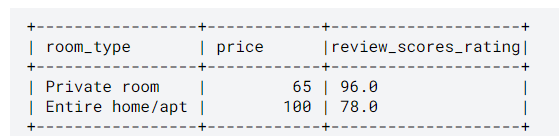
1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)
Среди представленных ниже графиков выберите корректный:


In [13]:
import seaborn as sns

In [26]:
query2 = """
SELECT 
    id,
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    toFloat32OrNull(review_scores_rating) as review_scores_rating
FROM 
    default.ldn_listings
WHERE 
    review_scores_rating IS NOT NULL
ORDER BY
    id ASC
LIMIT 1000
"""
df_ldn_listings = ph.read_clickhouse(query2, connection=connection_default)
price_vs_rating_mean = df_ldn_listings.groupby(['room_type'], as_index = False) \
    .agg({'price':'mean', 'review_scores_rating':'mean'})
price_vs_rating_mean

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


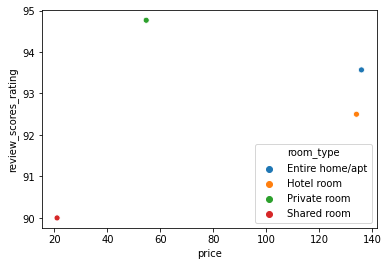

In [27]:
sns.scatterplot(data = price_vs_rating_mean, x = 'price', y = 'review_scores_rating', hue = 'room_type')

так, помимо аренды жилья, на Airbnb также есть "Впечатления"— мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите:

host_id – идентификатор хозяина
host_verifications – какими способами хост подтвердил свой профиль
Затем обработайте столбец host_verifications:

В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
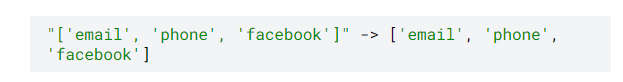
Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации
Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [93]:
query3 = """
SELECT 
    DISTINCT host_id,
    host_verifications
FROM 
    default.ldn_listings
WHERE 
    experiences_offered != 'none'
ORDER BY
    id ASC
"""
df_ldn_listings = ph.read_clickhouse(query3, connection=connection_default)
df_ldn_listings

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [94]:
df_ldn_listings['host_verifications'] = df_ldn_listings.host_verifications.str.strip('[]').str.replace("'",'').str.split(', ')
df_ldn_listings

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline_gove..."
1,60302,"[email, phone, reviews, jumio, government_id]"
2,67915,"[email, phone, jumio, selfie, government_id, i..."
3,167107,"[email, phone, manual_offline, jumio, offline_..."
4,103583,"[email, phone, reviews, offline_government_id,..."
...,...,...
1356,21558962,"[email, phone, reviews, jumio, government_id]"
1357,21257846,"[email, phone, reviews, jumio, offline_governm..."
1358,34219613,"[email, phone, reviews, jumio, government_id]"
1359,34299581,"[email, phone, google, reviews, jumio, offline..."


In [95]:
df_ldn_listings.explode('host_verifications') \
                                .host_verifications \
                                .value_counts() \
                                .to_frame(name='count')

,count
phone,1361
email,1345
reviews,1309
government_id,1196
jumio,1115
offline_government_id,469
work_email,279
facebook,270
selfie,252
identity_manual,227


Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count. Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – family.
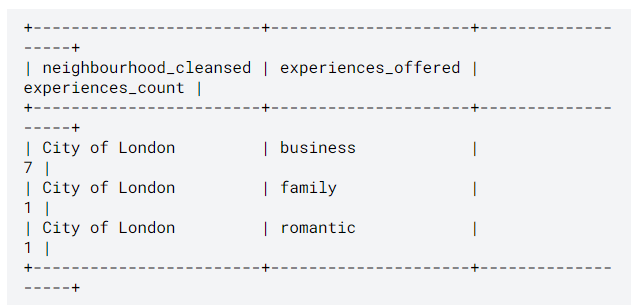
Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [96]:
query4 = """
SELECT 
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(*) AS experiences_count 
FROM 
    default.ldn_listings
WHERE 
    experiences_offered != 'none'
GROUP BY 
    neighbourhood_cleansed,
    experiences_offered
ORDER BY
    experiences_count DESC
LIMIT 100
"""
df_ldn_listings = ph.read_clickhouse(query4, connection=connection_default)
df_ldn_listings

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Merton,romantic,2
96,Redbridge,social,2
97,City of London,family,1
98,Barking and Dagenham,business,1


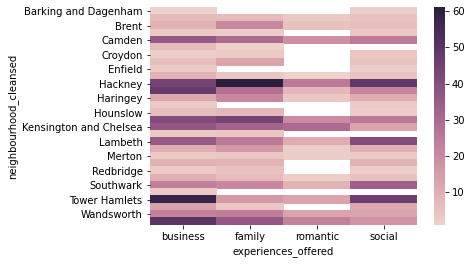

In [100]:
sns.heatmap(df_ldn_listings.pivot(index = 'neighbourhood_cleansed', 
                              columns = 'experiences_offered', 
                              values = 'experiences_count'),
                              cmap=sns.cubehelix_palette(as_cmap=True))

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')
Пример части результирующей таблицы:
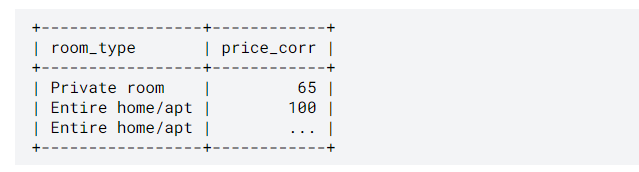
Далее постройте два графика, используя distplot из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())
Среди представленных графиков выберите два соответствующих.

In [119]:
query5 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM 
    default.ldn_listings
WHERE 
    experiences_offered != 'none'
"""
df_ldn_listings = ph.read_clickhouse(query5, connection=connection_default)
df_ldn_listings

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


In [120]:
import numpy as np
import matplotlib.pyplot as plt

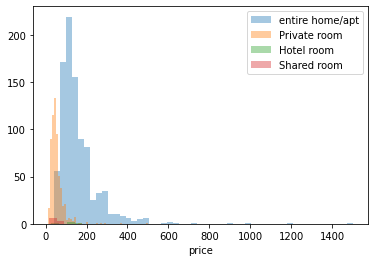

In [121]:
sns.distplot((df_ldn_listings.query('room_type == "Entire home/apt"').price), kde = False, label = 'entire home/apt')
sns.distplot((df_ldn_listings.query('room_type == "Private room"').price), kde = False, label = 'Private room')
sns.distplot((df_ldn_listings.query('room_type == "Hotel room"').price), kde = False, label = 'Hotel room')
sns.distplot((df_ldn_listings.query('room_type == "Shared room"').price), kde = False, label = 'Shared room')
plt.legend()
plt.show()

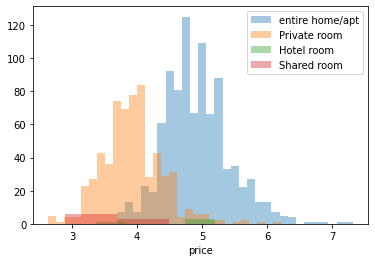

In [122]:
sns.distplot(np.log((df_ldn_listings.query('room_type == "Entire home/apt"').price)), kde = False, label = 'entire home/apt')
sns.distplot(np.log((df_ldn_listings.query('room_type == "Private room"').price)), kde = False, label = 'Private room')
sns.distplot(np.log((df_ldn_listings.query('room_type == "Hotel room"').price)), kde = False, label = 'Hotel room')
sns.distplot(np.log((df_ldn_listings.query('room_type == "Shared room"').price)), kde = False, label = 'Shared room')
plt.legend()
plt.show()

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.

In [135]:
query6 = """
SELECT 
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    first_review
FROM 
    default.ldn_listings
WHERE 
    experiences_offered != 'none'
LIMIT 1000
"""
df_ldn_listings = ph.read_clickhouse(query6, connection=connection_default)
df_ldn_listings

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,100.0,2009-12-21
2,Private room,150.0,
3,Private room,45.0,
4,Private room,25.0,2010-09-15
...,...,...,...
995,Entire home/apt,40.0,
996,Entire home/apt,150.0,2015-05-06
997,Entire home/apt,250.0,2014-10-03
998,Private room,28.0,2015-08-03


In [145]:
df = df_ldn_listings.groupby(['room_type', 'first_review']) \
    .agg({'price':'mean'})

In [146]:
sns.lineplot(data = df, x = 'first_review', y = 'price', hue = 'room_type')

ValueError: Could not interpret input 'first_review'